# Class Mean PCA

> Examining the space spanned by the class means in feature space

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from sklearn.decomposition import PCA
from fastai.vision.all import *

from similarity_learning.all import *

from Few_Shot_Feature_Space.utils import *

In [ ]:
def plot_variance_per_component(pca):
    plt.ylabel('Explained Variance')
    plt.bar(range(pca.n_components_), pca.explained_variance_)
    plt.axhline(pca.explained_variance_.mean(), label='Average Variance')
    plt.legend()

def test_pruning(fe, pca, variance_frac=.99):
    learn = Learner(LFWPairs().dev().dls(),
                ThresholdSiamese(fe),
                metrics=accuracy)
    learn.model.fit_threshold(learn.dls.train)

    full_var_acc = learn.validate()[1]

    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    n_comps, total_variance_frac = [(i+1, x) for i, x in enumerate(cumulative_variance) if x < variance_frac][-1]
    comps = Tensor(pca.components_[:n_comps]).cuda()
    proj_mat = comps.T @ comps
    learn.model = ThresholdSiamese(nn.Sequential(fe, Lambda(lambda x: x @ proj_mat)))

    learn.model.fit_threshold(learn.dls.train)

    print(f"LFW accuracy at 100% variance with {pca.n_components_} components: {full_var_acc*100:.3f}%",
          f"LFW accuracy at {total_variance_frac*100:.3f}% variance with {n_comps} components: {learn.validate()[1]*100:.3f}%",
          sep='\n')


def pca(dl, fe):
    class_ftrs = ClassFeatures.compute(dl, fe)
    class_means_stacked = torch.stack([cf.centroid for cf in class_ftrs.values()]).cpu()
    pca = PCA()
    pca.fit(class_means_stacked)

    plot_variance_per_component(pca)

    test_pruning(fe, pca)

In [ ]:
vggface2_fe, casia_webface_fe = fr_feature_extractors()
lfw_dl, pfr_dl = fr_dataloaders()

## VGGFace2

### LFW

LFW accuracy at 100% variance with 512 components: 99.200%
LFW accuracy at 98.182% variance with 47 components: 99.200%


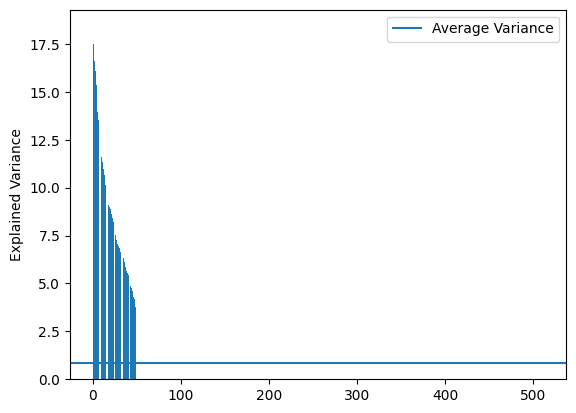

In [ ]:
pca(lfw_dl, vggface2_fe)

### PFR

LFW accuracy at 100% variance with 105 components: 99.200%
LFW accuracy at 98.791% variance with 43 components: 99.000%


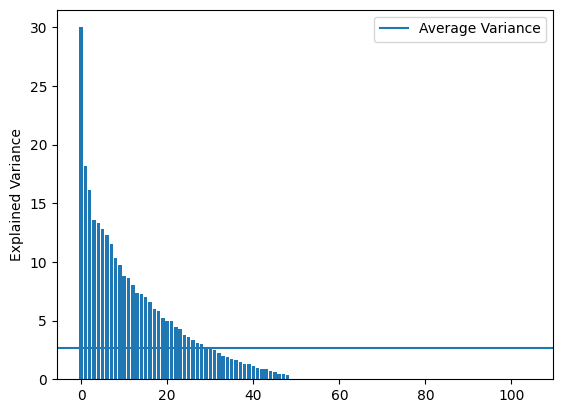

In [ ]:
pca(pfr_dl, vggface2_fe)

## CASIA-WebFace

### LFW

LFW accuracy at 100% variance with 512 components: 98.000%
LFW accuracy at 98.945% variance with 74 components: 98.000%


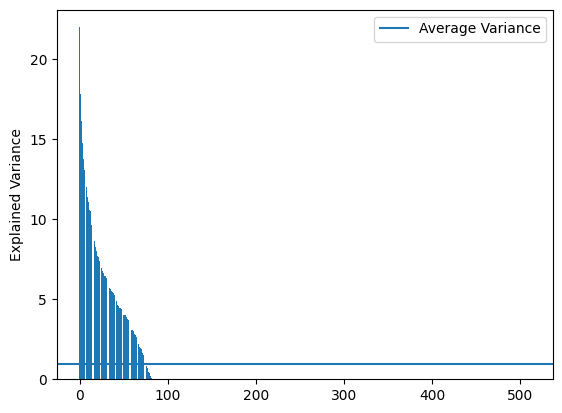

In [ ]:
pca(lfw_dl, casia_webface_fe)

LFW accuracy at 100% variance with 105 components: 98.000%
LFW accuracy at 98.965% variance with 60 components: 97.800%


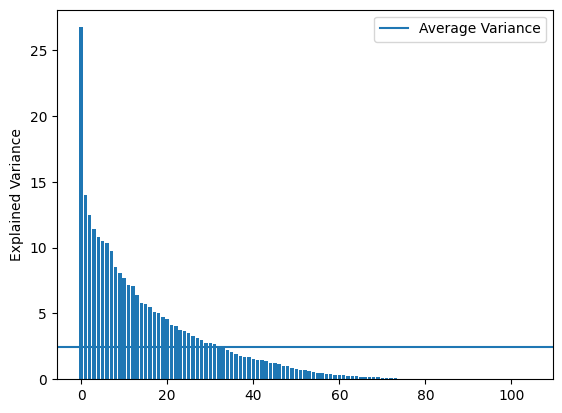

In [ ]:
pca(pfr_dl, casia_webface_fe)